In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from skimage import filters
from skimage.measure import label, regionprops, regionprops_table
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter
import scipy
import statistics
import math
from scipy import ndimage
import cv2

In [5]:
# Load Raw Images
img1 = plt.imread("./test1.tif")
img2 = plt.imread("./test2.tif")

In [6]:
# a function to quickly check images/arrays before and after a given function
def check_results(array1, array1_title, array2, array2_title):
        plt.figure(figsize = (12, 6), dpi = 80)
        plt.subplot(1, 2, 1)
        plt.title(array1_title)
        plt.imshow(array1, cmap = 'gray')
        
        ax = plt.subplot(1, 2, 2)
        plt.title(array2_title)
        plt.imshow(array2, cmap = 'gray')

In [7]:
# binarize a given image loaded in
def binarize(img, threshold=0, check=False):
    if threshold != 0:
        binary = img > threshold
    else:
        binary = img > (img1.mean() + 0.01*img.std())
    if check==True:
        check_results(img, 'before binary', binary, 'binary')
    return binary

In [8]:
# fill in holes that are falsely 1 or 0 to eliminate noise
# invert=True will flip all false to true and vice versa after filling in the holes
def fill_blobs(binary, invert=False, check=False):
    fill_binary = ndimage.binary_fill_holes(binary)
    if invert==True:
        fill_binary = np.invert(fill_binary)

    if check==True:
        check_results(binary, 'binary', fill_binary, 'filled')
    
    return fill_binary

In [9]:
# Obtain the minimum distance between a given pixel of interest and it's opposite value (0 to 1 or 1 to 0)
# this function is for single-droplet type scenarios only
def get_min_dist(binary, scale=0, check=False):
    # >0 will be at points where value = 1 in binary images
    # 0 will be at points where value = 0 in binary images
    # edt is euclidean distance transform, filled implies the image was filled before
    img1_edt_filled = ndimage.distance_transform_edt(binary)
    min_dists = []
    for i in range(len(img1_edt_filled)):
        for j in range(len(img1_edt_filled[i])):
            if scale != 0:
                if img1_edt_filled[i][j] != 0:
                    min_dists.append(img1_edt_filled[i][j]*scale)
            else:
                if img1_edt_filled[i][j] != 0:
                    min_dists.append(img1_edt_filled[i][j])
    if check==True:
        check_results(binary, 'binary', img1_edt_filled, 'measurements')
    return min_dists


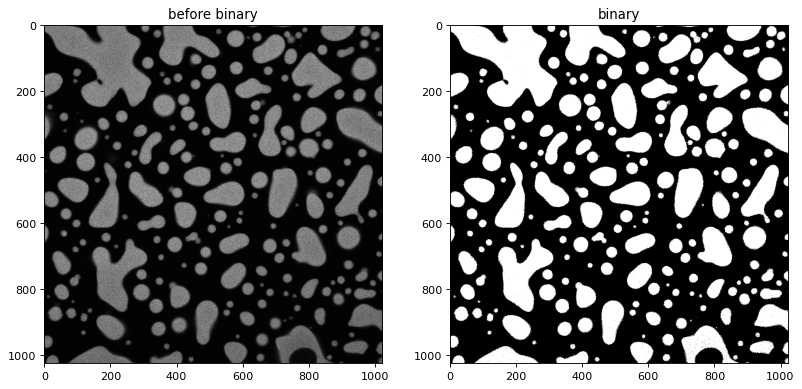

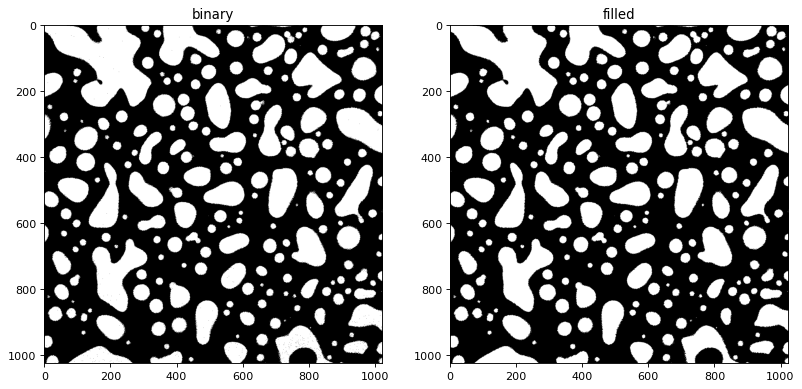

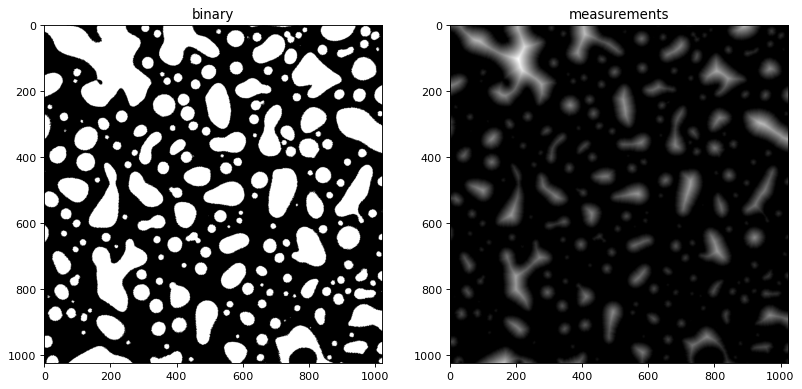

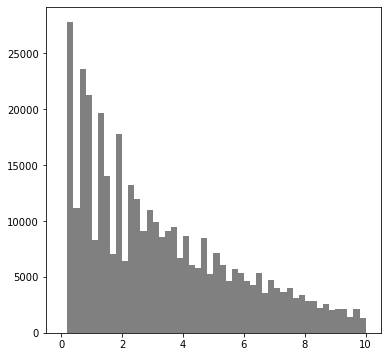

In [12]:
# example case
# shows before and after binarize, before and after filling, and the edt image
# followed by a histogram of the distances obtained
binary_img2 = binarize(img2, check=True)
filled_img2 = fill_blobs(binary_img2, check=True)
min_img2 = get_min_dist(filled_img2, scale=319.45/1024, check=True)
# obtains the minimum distance between a given point in NSD1 and the first pixel in the bulk phase
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

ax.hist(min_img2, bins = 50, range = (0,10), color = 'grey')

plt.show()

3.560128925408344
3.656810156173237
3.292647562349601
3.6638544712213


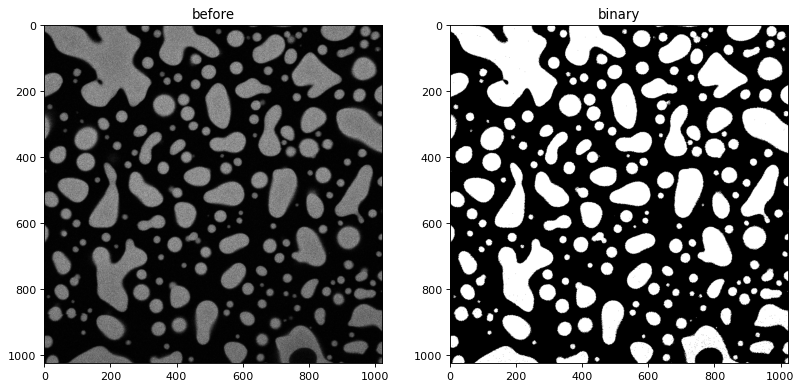

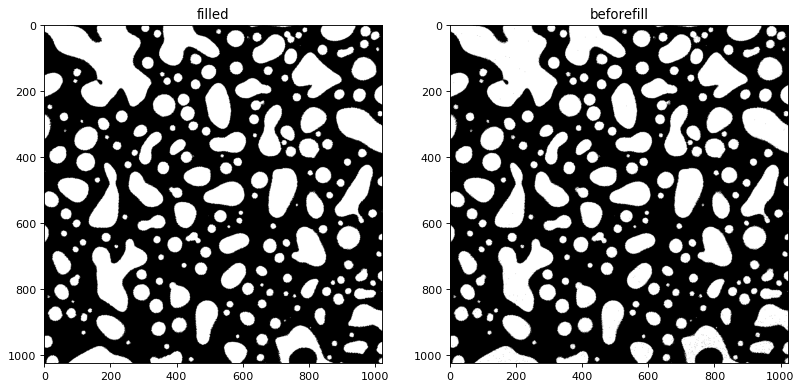

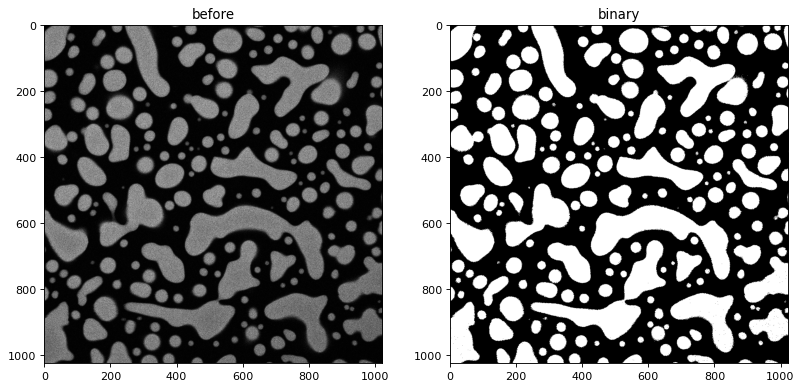

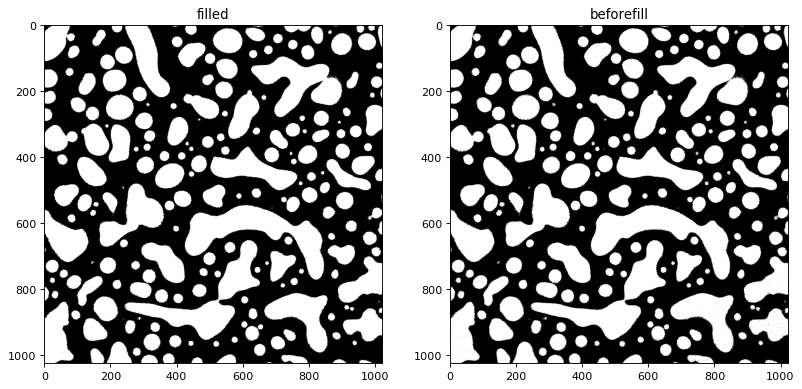

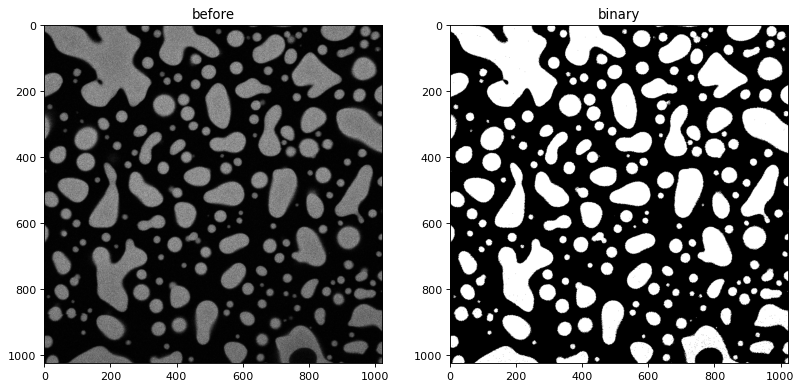

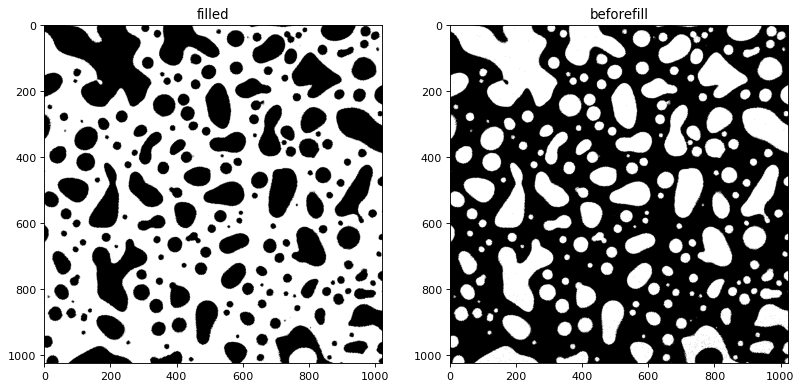

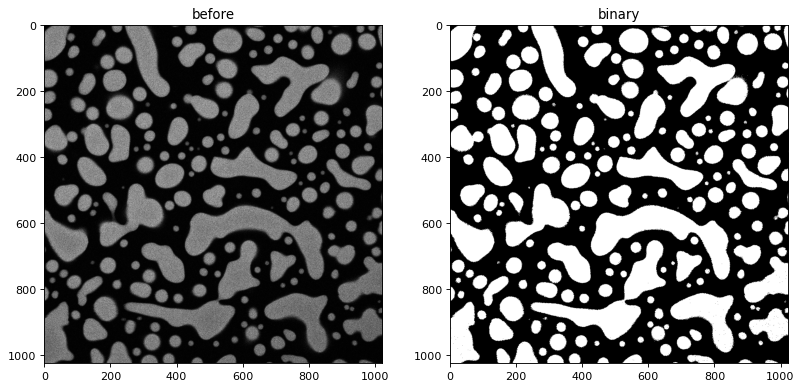

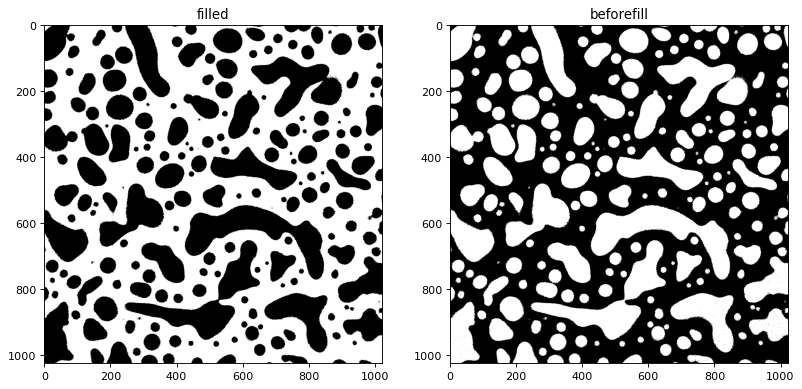

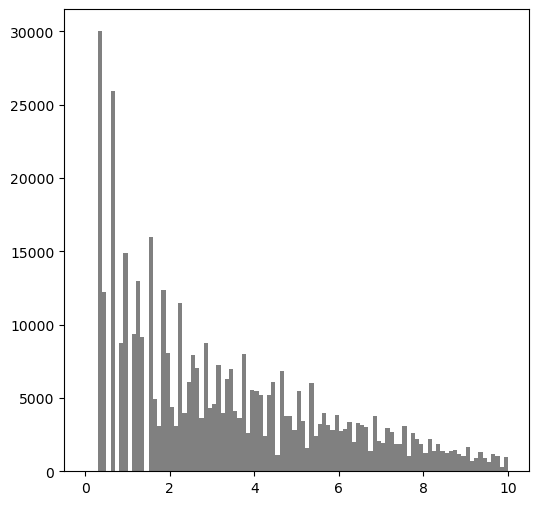

In [40]:
binary_img2 = binarize(img2)
filled_img2 = fill_blobs(binary_img2)
min_img2 = get_min_dist(filled_img2, scale=319.45/1024)

binary_img1 = binarize(img1)
filled_img1 = fill_blobs(binary_img1)
min_img1 = get_min_dist(filled_img1, scale=319.45/1024)

binary_bg2 = binarize(img2)
filled_bg2 = fill_blobs(binary_bg2, invert=True)
min_bg2 = get_min_dist(filled_bg2, scale=319.45/1024)

binary_bg1 = binarize(img1)
filled_bg1 = fill_blobs(binary_bg1, invert=True)
min_bg1 = get_min_dist(filled_bg1, scale=319.45/1024)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

# ax.hist(min_img2, bins = 100, range = (0,10), color = 'grey')
ax.hist(min_img1, bins = 100, range = (0,10), color = 'grey')

dist_drop1 = pd.DataFrame(min_img1)
dist_drop2 = pd.DataFrame(min_img2)
dist_bg1 = pd.DataFrame(min_bg1)
dist_bg2 = pd.DataFrame(min_bg2)

dist_drop1.to_csv('min_droplettobg_1.csv')
dist_drop2.to_csv('min_droplettobg_2.csv')
dist_bg1.to_csv('min_bgtodrop_1.csv')
dist_bg2.to_csv('min_bgtodrop_2.csv')


plt.show()

In [14]:
# function to mask NSD1 and NSD2 such that the droplet identities are separated in the NR channel
def mask_rec(sender, receiver, check=False):
    new_receiver = receiver.copy()
    for i in range(len(receiver)):
        for j in range(len(receiver[i])):
            if receiver[i][j] != 0 and receiver[i][j] == sender[i][j]:
                new_receiver[i][j] = 0
    if check==True:
        check_results(receiver, 'before processing', new_receiver, 'after processing')
    return new_receiver

In [20]:
def get_orth_min_dist(temp_NSD, rep_NSD, scale=0, check=False):
# obtains the minimum distance between a given point in a droplet 
# that contains a template NS (temp_NSD) and the edge of an orthogonal droplet (rep_NSD)
    min_dists = []
    # obtain euclidean distance transform of rep_NSD
    distances = ndimage.distance_transform_edt(rep_NSD)
    for i in range(len(distances)):
        for j in range(len(distances[i])):

            if scale !=0:
                if temp_NSD[i][j] != 0 and distances[i][j] != 0:
                    # distances[i][j] !=0 eliminates false distances of 0
                    min_dists.append(distances[i][j]*scale)

            else:
                if temp_NSD != 0 and distances[i][j] != 0:
                    min_dists.append(distances[i][j])

    if check==True:
        check_results(temp_NSD, 'droplets with template', distances, 'edt')
    return min_dists

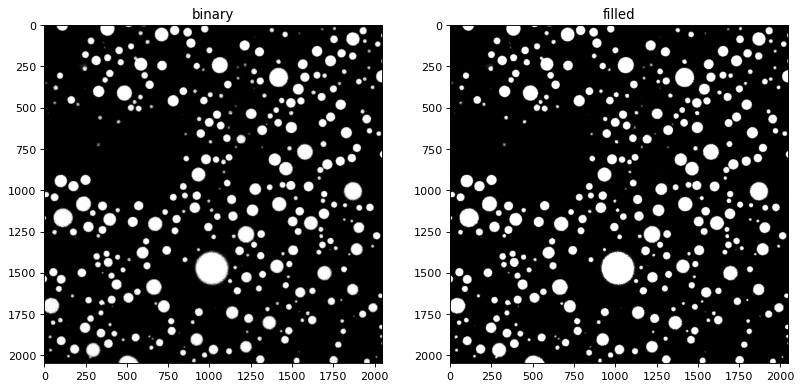

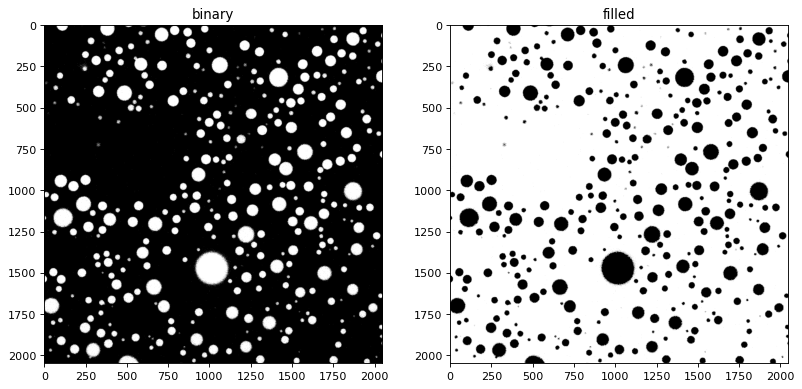

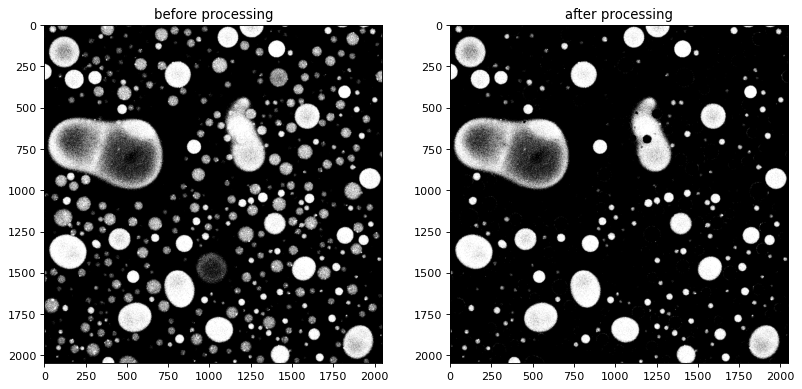

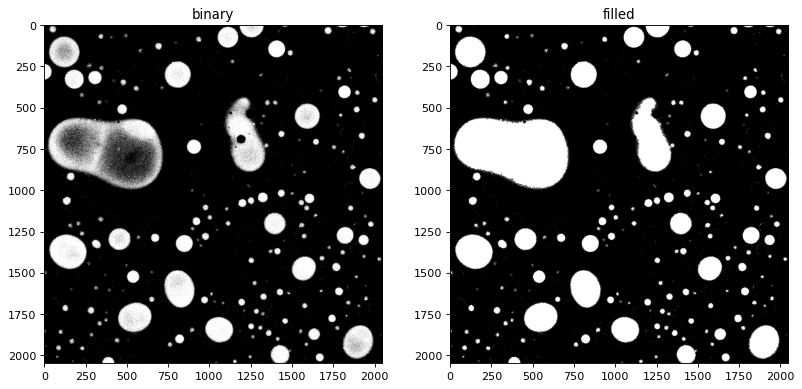

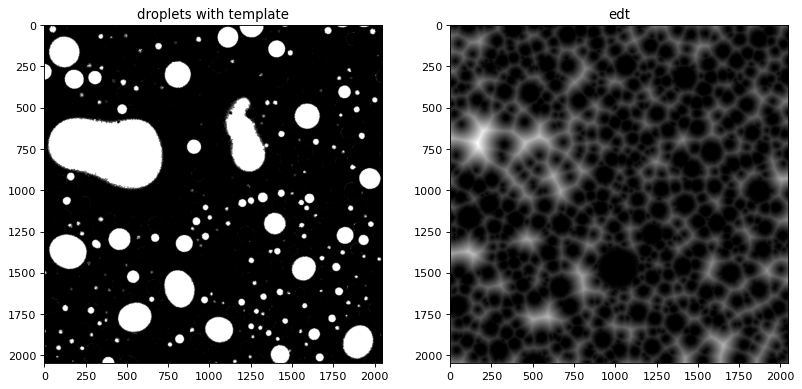

In [120]:
# Example of obtaining NSD2 --> NSD1 edge distances
NSD1_img1 = plt.imread('./Txn_series1_30min_sender.tif')
tempSE2_img1 = plt.imread('./Txn_series1_30min_receiver.tif')
# template is in NSD2 in this image
NSD1_binary = binarize(NSD1_img1)
NSD1_fill = fill_blobs(NSD1_binary, check=True)
# NSD1_fill is used for the mask of the reporter channel
NSD1_fill_for_edt = fill_blobs(NSD1_binary, invert=True, check=True)
# NSD1_fill_for_edt is used for obtaining edt

tempSE2_binary = binarize(tempSE2_img1)
tempSE2_masking = mask_rec(NSD1_fill, tempSE2_binary, check=True)
tempSE2_fill = fill_blobs(tempSE2_masking, check=True)

min_NSD2_3 = get_orth_min_dist(tempSE2_fill, NSD1_fill_for_edt, scale=319.45/2048, check=True)
print(statistics.mean(min_NSD2_3))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

# ax.hist(min_img2, bins = 100, range = (0,10), color = 'grey')
ax.hist(min_NSD2_3, bins = 100, color = 'grey')
dist_NSD2toNSD1 = pd.DataFrame(min_NSD2_3)

dist_NSD2toNSD1.to_csv('min_NSD2_to_NSD1.csv')

In [19]:
# Some images required erosion and dilation processing 
# as well as thresholding to eliminate noise
NSD1_dilate = cv2.dilate(NSD1_temp_img1.astype(float), (10,10), iterations=25)
check_results(NSD1_fill, 'before dilate', NSD1_dilate, 'after dilate')
NSD1_binary = binarize(NSD1_dilate, threshold=12000, check=True)

ModuleNotFoundError: No module named 'cv2'

NameError: name 'cv2' is not defined

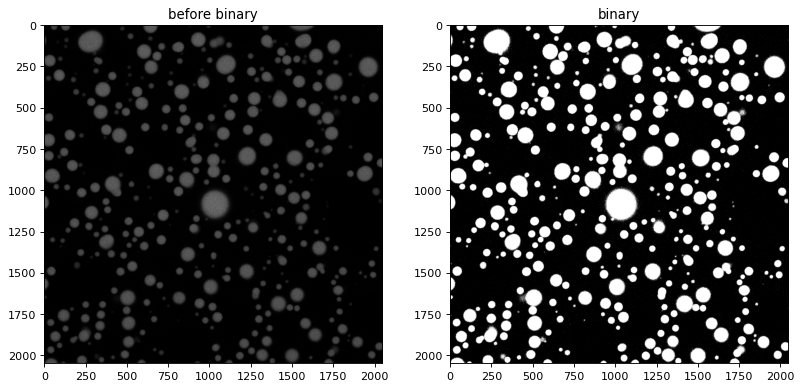

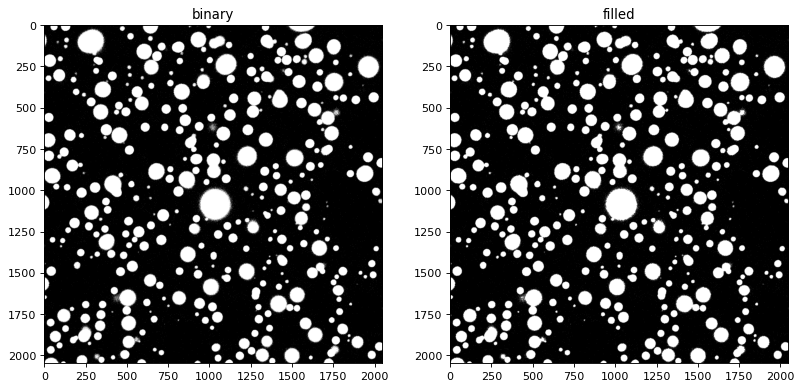

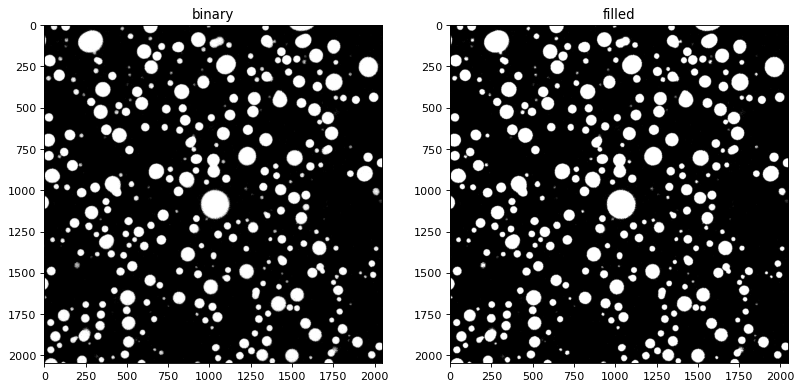

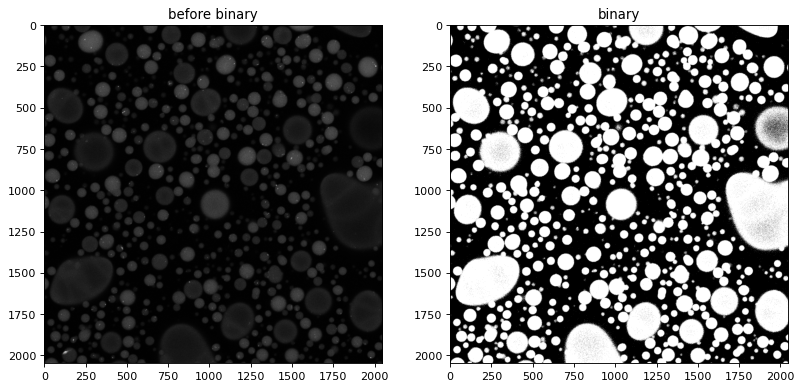

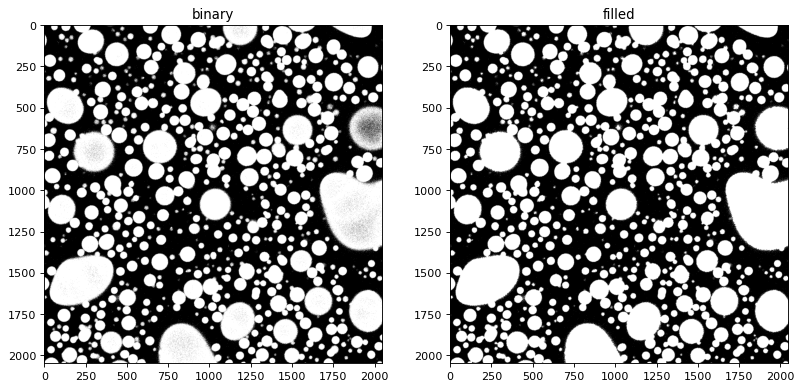

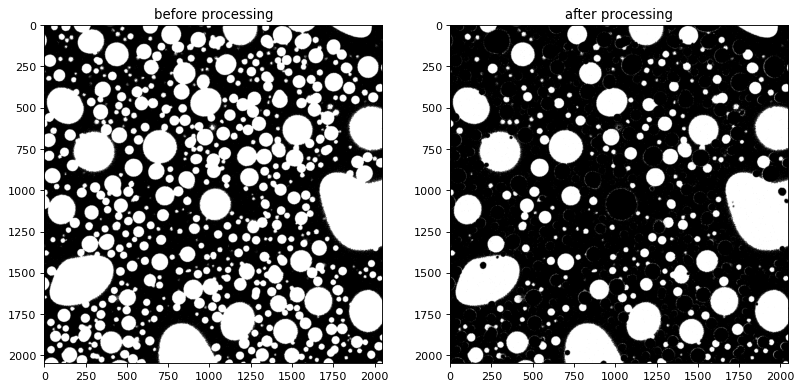

In [18]:
# example of obtaining NSD1 --> NSD2 edge distances when implementing erosion/dilation processing
NSD1_temp_img1 = plt.imread('./Txn_series6_30min_sender.tif')
rec_img1 = plt.imread('./Txn_series6_30min_receiver.tif')
NSD1_binary = binarize(NSD1_temp_img1, threshold=3000, check=True)
# this NSD1_binary is used for the mask to minimize noise in the reporter channel
NSD1_fill = fill_blobs(NSD1_binary, check=True)
NSD1_act_binary = binarize(NSD1_temp_img1)
# this NSD1_act_binary is the actual NSD1 binary image observed
NSD1_act_fill = fill_blobs(NSD1_act_binary, check=True)

rec_binary = binarize(rec_img1, threshold=3000, check=True) # threshold accounts for low intensity holes in droplets
rec_fill = fill_blobs(rec_binary, check=True)
rec_mask = mask_rec(NSD1_fill, rec_fill, check=True)
# masked with the thresholded NSD1 for better masking

rec_erode = cv2.erode(rec_mask.astype(float), (5,5), iterations=5)
# eliminate pixels that should not be present as True
check_results(rec_mask, 'before', rec_erode, 'after')
rec_dilate = cv2.dilate(rec_erode.astype(float), (5,5), iterations=5)
# refill pixels affected by the erosion
check_results(rec_erode, 'before', rec_dilate, 'after')
rec_invert = 1-rec_dilate
check_results(rec_dilate, 'before', rec_invert, 'after')
min_NSD1_1 = get_orth_min_dist(NSD1_act_fill, rec_invert, scale=319.45/2048, check=True)

print(statistics.mean(min_NSD1_1))
print(statistics.stdev(min_NSD1_1))
print(min(min_NSD1_1))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

ax.hist(min_NSD1_1, bins = 100, color = 'grey')
# dist_NSD1toNSD2 = pd.DataFrame(min_NSD1_1)

# dist_NSD1toNSD2.to_csv('min_NSD1_to_NSD2_1.csv')
